## Load libraries

In [1]:
library(plyr)
library(dplyr)
library(reshape)
library(ggplot2)
library(RColorBrewer)
library(reshape)
library(reshape2)
library(tidyverse)
library(repr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename


The following objects are masked from ‘package:plyr’:

    rename, round_any



Attaching package: ‘reshape2’


The following objects are masked from ‘package:reshape’:

    colsplit, melt, recast


── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8     ✔ purrr   0.3.5
✔ tidyr   1.2.1     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────

## Set paths to reference files

In [2]:
#Set pct cutoff
pct_cutoff=0.05

#Read fold changes between primary tumor and respective CNCs for DACRs
fch=read.table('../data/snATAC/FoldChange_Tumor_vs_CNC_DACRs.tsv', header=T, sep='\t')

#Read primary tumor vs CNC DACRs
dacrs=read_delim('../data/snATAC/Table_S2e_cancer_DACRs.txt', delim='\t', show_col_types = FALSE)
dacrs=as.data.frame(dacrs)

#Read gene list annotation from HGNC
genes_list=read.csv('../data/Gene_lists/hgnc-gene_list.txt',sep='\t')
genes_prot_c=genes_list[genes_list$Locus.type=='Gene with protein product',]

#Set color scale
cols <- c("#386cb0","#386cb0","#386cb0","white","white","#d73027","#d73027","#d73027")

In [3]:
fch_h=fch[,c('avg_log2FC', 'peak', 'Disease', 'pct.1')]

#Keep annotation of unique peaks from DACRs list
dacrs_s=dacrs[,c('Gene', 'peak', 'Type')]
dacrs_s=dacrs_s[!duplicated(dacrs_s),]

#Add annotation to table with peaks and fold changes
fch_h=merge(fch_h, dacrs_s, all.x=T)

In [4]:
#Keep DACRs only from the list of genes with protein products
dacrs=dacrs[dacrs$Gene %in% genes_prot_c$Symbol,]

#Keep DACRs with fold change>0, p_val_adj<0.05, and percentage of expressed cells>pct_cutoff
dacrs_2=dacrs[dacrs$avg_log2FC>0 & dacrs$p_val_adj<0.05 & dacrs$pct.1>pct_cutoff,]

In [5]:
#Make summary table to identify top shared across cancers DACRs
stat=dcast(dacrs_2,peak~Cancer, value.var='avg_log2FC')
stat$Count_up=apply(stat[,-1],1,function(x) length(x[!is.na(x)]))
stat$avg_fch=apply(stat[,c(2:(ncol(stat)-1))],1,function(x) mean(x,na.rm=T))
                   
#Add peaks annotation and order based on fold change, and then based on number of up-regulated ones across cancers
stat_s=merge(stat,dacrs_s,all.x=T)
stat_s=stat_s[order(-stat_s$avg_fch),]
stat_s=stat_s[order(-stat_s$Count_up),]

In [6]:
#For specific DACRs analysis, make a list of DACRs with positive fold changes in <50% of cancers (<6 cancers)
fch_filt=fch[fch$avg_log2FC>0 & fch$pct.1>pct_cutoff,]
stat_fch=dcast(fch_filt,peak~Disease, value.var='avg_log2FC')
stat_fch$Count_up=apply(stat_fch[,-1],1,function(x) length(x[!is.na(x)]))
stat_fch$avg_fch=apply(stat_fch[,c(2:(ncol(stat)-1))],1,function(x) mean(x,na.rm=T))

stat_fch_s=merge(stat_fch,dacrs_s,all.x=T)
stat_fch_s1=stat_fch_s[stat_fch_s$Count_up<6,]

In [7]:
#Prepare table for more cancer-specific DACRs prioritization
dacrs_up=dacrs[dacrs$avg_log2FC>0 & dacrs$p_val_adj<0.05 & dacrs$pct.1>pct_cutoff,]
dacrs_up=dacrs_up[(dacrs_up$peak %in% stat_fch_s1$peak),]
dacrs_up=dacrs_up[order(-dacrs_up$avg_log2FC),]
dacrs_up=dacrs_up[!duplicated(dacrs_up[,c('Cancer','Gene')]),]
cancers=unique(dacrs_up$Cancer)

In [8]:
#Identify top DACRs in each cancer
all_tab=NULL
for (can in cancers){
    dacrs_up_s=dacrs_up[dacrs_up$Cancer==can,][1:7,]

    all_tab=rbind(all_tab,dacrs_up_s)
}
all_tab=all_tab[!is.na(all_tab$Gene),]


In [9]:
#Also add two additional specific DACRs
dacrs_add=dacrs[(dacrs$peak=='chr2-218896940-218897440' & dacrs$Cancer=='PDAC') | (dacrs$peak=='chr21-42227980-42228480' & dacrs$Cancer=='ccRCC'),]

all_tab=rbind(all_tab,dacrs_add)

In [10]:
stat_all=dcast(fch_h,peak~Disease, value.var='avg_log2FC')
stat_s1=stat_all

#top 15 shared DACRs, that also have positive fold change in >50% of cancers,
# and not in the list of peaks stat_fch_s1$peak
top_shared_dacrs=stat_s$peak[!(stat_s$peak %in% stat_fch_s1$peak)][1:15]

#Make table with selected DACRs (shared and more specific)
stat_s1=stat_s1[stat_s1$peak %in% c(top_shared_dacrs,all_tab$peak), ]

In [11]:
#Format table
rownames(stat_s1)=stat_s1$peak
stat_s1=stat_s1[,-1]

stat_s2=melt(as.matrix(stat_s1))
colnames(stat_s2)=c('peak','Disease','FoldChange')

In [12]:
#Now annotate those DACRs, as shared and more specific
all_tab=all_tab[order(-all_tab$avg_log2FC),]
all_tab=all_tab[!duplicated(all_tab$peak),]
all_tab_s=all_tab[,c('Cancer','Gene','peak')]
colnames(all_tab_s)[1]='Peak_type'

stat_s2=merge(stat_s2,all_tab_s,all.x=T)
stat_s3=merge(stat_s2[,1:4],fch_h,all.x=T)

top_shared_dacrs=stat_s$peak[!(stat_s$peak %in% stat_fch_s1$peak)][1:15]
stat_s3$Peak_type=ifelse(stat_s3$peak %in% top_shared_dacrs,'Shared',stat_s3$Peak_type)
shared_dacrs_genes=unique(stat_s3$Gene[stat_s3$Peak_type=='Shared'])
stat_s3=stat_s3[!(stat_s3$Peak_type!='Shared' & stat_s3$Gene %in% shared_dacrs_genes),]


In [13]:
stat_s4=stat_s3

#remove HNSCC (just one DACR was found)
stat_s4=stat_s4[stat_s4$Peak_type!='HNSCC',]
stat_s4$Disease=factor(stat_s4$Disease,levels=rev(c('HNSCC','CESC','PDAC','CRC','MM','BRCA','BRCA_Basal','OV','UCEC','GBM','ccRCC','SKCM')))
stat_s4$Peak_type=factor(stat_s4$Peak_type,levels=c('Shared','HNSCC','CESC','PDAC','CRC','MM','BRCA','BRCA_Basal','OV','UCEC','GBM','ccRCC','SKCM'))


In [14]:
#Cap fold change at 1.5 
stat_s5=stat_s4[stat_s4$avg_log2FC>0,]
stat_s5$avg_log2FC=ifelse(stat_s5$avg_log2FC>1.5,1.5, stat_s5$avg_log2FC)
stat_s5$avg_log2FC=ifelse(-stat_s5$avg_log2FC>1.5,-1.5, stat_s5$avg_log2FC)

In [15]:
#Add p_val_adj:
dacrs_sel=dacrs[,c('Cancer','peak','p_val_adj')]
colnames(dacrs_sel)[1]='Disease'
stat_s7=merge(stat_s5,dacrs_sel,all.x=T)

#Keep only those with pct_cutoff>=0.05
stat_s7=stat_s7[stat_s7$pct.1>=0.05,]

## Do plotting

In [16]:
p <- ggplot(data = stat_s7, mapping = aes(x = Gene, y = Disease))

p <- p + geom_point( mapping = aes(fill = avg_log2FC, size = pct.1),pch=21)
      
p <- p + theme(axis.title.x = element_blank(), axis.title.y = element_blank())# +scale_radius()

p <- p + guides(size = guide_legend(title = 'Percent Expressed'))

p <- p + scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0)

p <- p + facet_grid(.~Peak_type,drop=T,scales = "free", space = "free")

p <- p + theme_bw()

p <- p + theme(panel.spacing.x = unit(0, "lines"), panel.spacing.y = unit(0, "lines"))

p <- p + theme(axis.text.y = element_text(size = 10, face = "bold"))

p <- p + theme(axis.text.x = element_text(size = 10, face = "bold", angle = 90, hjust = 0.95, vjust = 0.2))

p <- p + theme(panel.grid.major = element_line(size = 0.5, linetype = 'solid', colour = "grey80"))

p <- p + theme(strip.text.x = element_text(angle = 0))

p <- p + scale_size_continuous(range  = c(1, 4), limits = c(pct_cutoff, max(stat_s7$pct.1)), breaks = c(0.05, 0.15, 0.25,0.35))

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


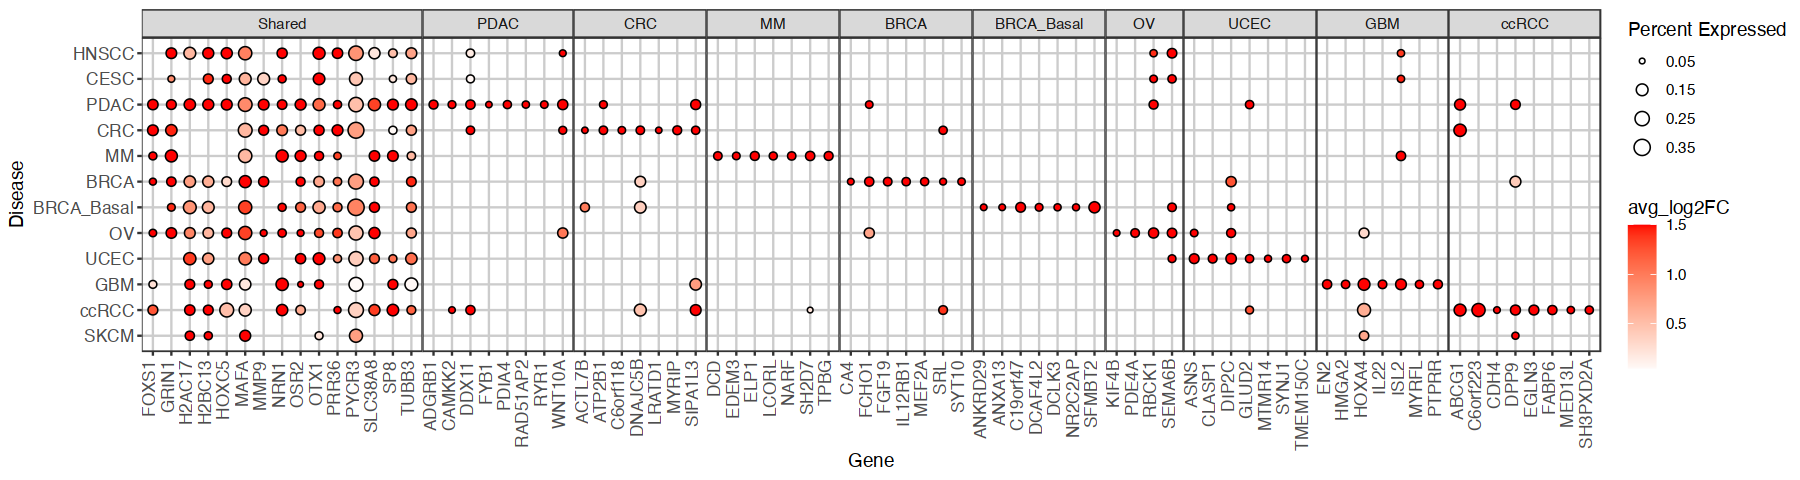

In [17]:
options(repr.plot.width=15, repr.plot.height=4)

p
